# Training Notebook for Ceramic Core Defect Detection

This notebook provides code to train the ResNet18-based model using the optimal training methodology, data augmentations, and hyperparameters discussed in the project report. The function of each cell is explained in text above the cell, and example outputs are included below each cell. 

### Requirements 

* Jupyter notebook should be opened through anaconda using the ```MECH5845M-CPU/CUDA-condaenv.yaml```
  * Use of CUDA is recommended to speed up training, but requires an Nvidia GPU with an installed CUDA driver
* A labelled dataset in the following directory format:
  * All images should be 224x224 px, generated using ```image_splitter.ipynb```
```
├── dataset
│   ├── OK
│   │   ├── **.jpg
│   ├── flash
│   │   ├── **.jpg
│   ├── defect
│   │   ├── **.jpg
```

Import all required functions and libraries.

`torch` and `torchvision` are the key libraries for deep learning and computer vision.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from torchinfo import summary

import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms.v2 as transforms
import torchvision.models as models

from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# This increases the quality of saved figures
plt.rcParams['savefig.dpi'] = 300

This class inherits from the `torch.Dataset` class, and just allows us to apply new transforms to existing `Dataset` objects. Used later on to apply different transforms to the train, validation, and test subsets.

In [2]:
class MyDataset(torch.utils.data.Dataset):
    # Class to allow different image transforms on different sections of the dataset
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

This function is used to find the mean and standard deviation of the training dataset, for input into the normalisation transform.

In [3]:
def norm_calcs(dataset):
    '''
    Finds the mean and standard deviation of an input torch.Dataset object

    Parameters: 
        dataset (torch.Dataset obj.): The training dataset

    Returns:
        tuple:  (mean, std) where mean and std are torch tensors of shape (3,)     
    '''
    norm_loader = DataLoader(dataset, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)

    print('Calculating mean and std of dataset...')
    for inputs, _labels in tqdm(norm_loader):
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return(mean, std)

This cell loads the dataset into `torch.DataLoader` objects for efficient loading during model training.

The dataset is first randomly split into test, validation and training subsets with an 80:10:10 split.
* If more data is available, this could be edited to have images of different cores in each subset, still with the 80:10:10 split.

Then image augmentations are applied to each dataset using the `MyDataset` class, and the datasets are passed into `DataLoaders`

An optional flag `dataset_balancing_enable` is provided to implement a `WeightedRandomSampler`, however this is disabled by default due to the results shown in the project report.

In [4]:
# Batch size for training, must be a power of 2 for the GPU to work efficiently
batch_size = 16     # optimum found in testing

# Flag to enable use of weighted random sampler to balance the dataset 
# Did not improve performance during testing for the project 
dataset_balancing_enable = False

# Load the dataset from a folder
dataset = datasets.ImageFolder(root="../Core1_Fulls/Core1_splits_overlap")

# Calculate the lengths of the train, test and validation datasets
test_length = int(len(dataset)/10)
val_length = int(len(dataset)/10)
train_length = len(dataset) - test_length - val_length 

# Randomly split data into datasets - 80:10:10 train val test split
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_length, test_length, val_length])

# Calculate mean and std of train dataset
norm_dataset = MyDataset(train_dataset, transform=transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]))
mean, std = norm_calcs(norm_dataset)

# Create data transforms for each dataset
data_transforms = {
    'train': transforms.Compose([transforms.ToImage(), 
                                 transforms.ToDtype(torch.float32, scale=True), 
                                 transforms.RandomHorizontalFlip(p=0.5),    # Randomly flip images horizontally
                                 transforms.RandomRotation([-15,15]),       # Randomly rotate images by up to 15 degrees in either direction
                                 transforms.Normalize((mean[0].item(), mean[1].item(), mean[2].item()), 
                                                      (std[0].item(), std[1].item(), std[2].item()))
                                ]),
    'test': transforms.Compose([transforms.ToImage(), 
                                transforms.ToDtype(torch.float32, scale=True),
                                transforms.Normalize((mean[0].item(), mean[1].item(), mean[2].item()), 
                                                     (std[0].item(), std[1].item(), std[2].item()))
                               ]),
    'val': transforms.Compose([transforms.ToImage(), 
                               transforms.ToDtype(torch.float32, scale=True),
                               transforms.Normalize((mean[0].item(), mean[1].item(), mean[2].item()), 
                                                    (std[0].item(), std[1].item(), std[2].item()))
                               ])
}

# Apply the transforms to each dataset
train_dataset = MyDataset(train_dataset, transform=data_transforms['train'])
test_dataset = MyDataset(test_dataset, transform=data_transforms['test'])
val_dataset = MyDataset(val_dataset, transform=data_transforms['val'])

# Print the lengths of each dataset
print(f'Train set size = {train_dataset.__len__()}')
print(f'Validation set size = {val_dataset.__len__()}')
print(f'Test set size = {test_dataset.__len__()}')

# Create DataLoaders for each dataset
# Check if weighted random sampler should be used
if dataset_balancing_enable:
    # WeightedRandomSampler setup
    # Get all labels from the train_dataset
    targets = [label for _, label in train_dataset]
    
    # Count the number of samples per class
    class_sample_count = np.bincount(targets)
    
    # Compute weights: inverse of class frequency
    weights = 1. / class_sample_count
    
    # Assign weight to each sample
    sample_weights = [weights[label] for label in targets]
    
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=sampler)
    
else:
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

Calculating mean and std of dataset...


100%|██████████| 8089/8089 [00:16<00:00, 479.51it/s]

Train set size = 8089
Validation set size = 1011
Test set size = 1011


This cell displays one batch from the training subset. 

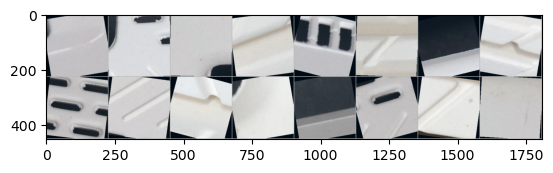

In [5]:
def imshow(img, norm=True):
   '''
   Function to display a batch of training images.

   Parameters:
         img (torch.Tensor): Image input from dataloader
         norm (bool): Whether the input image has been normalised
   '''
   npimg = img.numpy()
   if norm:
        maxval = np.max(npimg)
        minval = np.min(npimg)
        npimg = (npimg - minval) / (maxval - minval)
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

# get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
# show images
imshow(torchvision.utils.make_grid(images), norm=True)

Initialises a pre-trained ResNet18 model. As discussed in the project report, fine-tuning by unfreezing layers 3 and 4 of the architecture showed best performance.

In [6]:
# Device agnostic code to use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Loads the pre-trained ResNet18 model with ImageNet weights
model = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features

# All parameters are frozen by default
for param in model.parameters():
    param.requires_grad=False

# Layers 3 and 4 are unfrozen for fine-tuning
for param in model.layer3.parameters():
    param.requires_grad=True

for param in model.layer4.parameters():
    param.requires_grad=True
    
# The final fully connected layer is replaced to match the number of classes in the dataset
model.fc = nn.Linear(num_ftrs, 3)
model.fc.requires_grad=True

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Print a summary using torchinfo
# Uncomment the following lines to print the model summary

# summary(model=model, 
#         input_size=(64, 3, 224, 224), 
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

Defines the loss function and the optimiser. 

The loss function used is *Cross Entropy Loss*, a commonly used function in image classification models.

The optimiser is a mini-batch stochastic gradient descent algorithm with momentum. The parameter `lr` is the *learning rate*, which defines the magnitude of the layer weight change each iteration. The value of this was optimised during hyperparameter tuning.

In [7]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0002562099498900997, momentum=0.9)

Time to train the model!

Each epoch the entire training and validation datasets are seen by the model.

First, in training mode (using `model.train`):
* The model attempts to classify images in a training batch
* The loss in its predictions are calculated using the loss function defined above
* The optimiser uses this loss to calculate gradients and adjust layer weights using backpropagation (starting at the layers closest to the output)
* This happens for all batches in the training dataset
* The average training loss for the epoch is calculated

Then, in evaluation mode (using `model.eval()`)
* The model attempts to classify images in a validation batch
* The loss in its predictions are calculated 
* Gradients are **not** calculated and weights are not changed
* This happens for all batches in the validation dataset
* The average validation loss for the epoch is calculated

In [8]:
# Set the number of epochs for training
num_epochs=100

# Store training and validation losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    # Model in training mode
    model.train()
    train_loss = 0.0
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data) # Model prediction
        loss = criterion(scores, targets)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader) # average training loss
    train_losses.append(train_loss)
    print(f'Epoch training loss = {train_loss}')
    
    # Eval mode for validation 
    # Stops the model updating gradients 
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_index, (data, targets) in enumerate(tqdm(val_loader)):
            data = data.to(device)
            val_targets = targets.to(device)
            val_scores = model(data)
            loss = criterion(val_scores, val_targets)
            val_loss += loss.item()

    val_loss /= len(val_loader) # average validation loss
    val_losses.append(val_loss)
    print(f'Epoch validation loss = {val_loss}')

    # Uncomment to save the model weights every epoch

    # weight_name = 'ResNet18_weights_epoch_' + str(epoch) + '.pth'
    # torch.save(model.state_dict(), weight_name)

# Save the final model weights after training
torch.save(model.state_dict(), 'ResNet18_final_weights.pth')

Epoch [1/100]


100%|██████████| 506/506 [00:32<00:00, 15.79it/s]


Epoch training loss = 0.5956815539789294


100%|██████████| 64/64 [00:02<00:00, 21.47it/s]


Epoch validation loss = 0.4151781538967043
Epoch [2/100]


100%|██████████| 506/506 [00:31<00:00, 15.98it/s]


Epoch training loss = 0.39482326995537215


100%|██████████| 64/64 [00:03<00:00, 19.83it/s]


Epoch validation loss = 0.350261845276691
Epoch [3/100]


100%|██████████| 506/506 [00:32<00:00, 15.48it/s]


Epoch training loss = 0.3366197670254076


100%|██████████| 64/64 [00:02<00:00, 21.38it/s]


Epoch validation loss = 0.2959420070401393
Epoch [4/100]


100%|██████████| 506/506 [00:32<00:00, 15.80it/s]


Epoch training loss = 0.29675219707897765


100%|██████████| 64/64 [00:02<00:00, 22.35it/s]


Epoch validation loss = 0.2834810282802209
Epoch [5/100]


100%|██████████| 506/506 [00:31<00:00, 16.14it/s]


Epoch training loss = 0.2789689092878473


100%|██████████| 64/64 [00:02<00:00, 22.42it/s]


Epoch validation loss = 0.24964024589280598
Epoch [6/100]


100%|██████████| 506/506 [00:33<00:00, 15.04it/s]


Epoch training loss = 0.25348860261365475


100%|██████████| 64/64 [00:02<00:00, 22.53it/s]


Epoch validation loss = 0.21884311264147982
Epoch [7/100]


100%|██████████| 506/506 [00:31<00:00, 16.14it/s]


Epoch training loss = 0.23500587258546837


100%|██████████| 64/64 [00:02<00:00, 21.92it/s]


Epoch validation loss = 0.20076142795733176
Epoch [8/100]


100%|██████████| 506/506 [00:31<00:00, 16.01it/s]


Epoch training loss = 0.22396511168922242


100%|██████████| 64/64 [00:02<00:00, 22.30it/s]


Epoch validation loss = 0.2050349463825114
Epoch [9/100]


100%|██████████| 506/506 [00:31<00:00, 16.05it/s]


Epoch training loss = 0.2059948697774542


100%|██████████| 64/64 [00:03<00:00, 20.82it/s]


Epoch validation loss = 0.19492022501071915
Epoch [10/100]


100%|██████████| 506/506 [00:31<00:00, 15.96it/s]


Epoch training loss = 0.19296067030253736


100%|██████████| 64/64 [00:02<00:00, 22.58it/s]


Epoch validation loss = 0.1731385658349609
Epoch [11/100]


100%|██████████| 506/506 [00:32<00:00, 15.73it/s]


Epoch training loss = 0.18879425797699823


100%|██████████| 64/64 [00:02<00:00, 22.59it/s]


Epoch validation loss = 0.177232030488085
Epoch [12/100]


100%|██████████| 506/506 [00:31<00:00, 15.84it/s]


Epoch training loss = 0.16711990847049848


100%|██████████| 64/64 [00:02<00:00, 22.83it/s]


Epoch validation loss = 0.16186586803087266
Epoch [13/100]


100%|██████████| 506/506 [00:31<00:00, 16.15it/s]


Epoch training loss = 0.15265172724924952


100%|██████████| 64/64 [00:02<00:00, 23.21it/s]


Epoch validation loss = 0.15529611948295496
Epoch [14/100]


100%|██████████| 506/506 [00:31<00:00, 16.32it/s]


Epoch training loss = 0.153195015471355


100%|██████████| 64/64 [00:02<00:00, 22.88it/s]


Epoch validation loss = 0.143594672654217
Epoch [15/100]


100%|██████████| 506/506 [00:30<00:00, 16.42it/s]


Epoch training loss = 0.15372411210988116


100%|██████████| 64/64 [00:02<00:00, 22.41it/s]


Epoch validation loss = 0.14016015512606828
Epoch [16/100]


100%|██████████| 506/506 [00:30<00:00, 16.34it/s]


Epoch training loss = 0.1326567323283907


100%|██████████| 64/64 [00:03<00:00, 21.14it/s]


Epoch validation loss = 0.14000665459025186
Epoch [17/100]


100%|██████████| 506/506 [00:30<00:00, 16.56it/s]


Epoch training loss = 0.1287794041248561


100%|██████████| 64/64 [00:02<00:00, 21.49it/s]


Epoch validation loss = 0.15779622590343934
Epoch [18/100]


100%|██████████| 506/506 [00:30<00:00, 16.35it/s]


Epoch training loss = 0.12219265416603196


100%|██████████| 64/64 [00:02<00:00, 23.40it/s]


Epoch validation loss = 0.14879504741202254
Epoch [19/100]


100%|██████████| 506/506 [00:30<00:00, 16.50it/s]


Epoch training loss = 0.11431151255505093


100%|██████████| 64/64 [00:02<00:00, 22.78it/s]


Epoch validation loss = 0.1331926894490607
Epoch [20/100]


100%|██████████| 506/506 [00:31<00:00, 16.30it/s]


Epoch training loss = 0.11385299756307626


100%|██████████| 64/64 [00:02<00:00, 22.91it/s]


Epoch validation loss = 0.13742137963708956
Epoch [21/100]


100%|██████████| 506/506 [00:30<00:00, 16.37it/s]


Epoch training loss = 0.11155263297057347


100%|██████████| 64/64 [00:02<00:00, 22.16it/s]


Epoch validation loss = 0.1562054448913841
Epoch [22/100]


100%|██████████| 506/506 [00:31<00:00, 16.08it/s]


Epoch training loss = 0.09797664401038612


100%|██████████| 64/64 [00:02<00:00, 23.16it/s]


Epoch validation loss = 0.14714224241652119
Epoch [23/100]


100%|██████████| 506/506 [00:34<00:00, 14.80it/s]


Epoch training loss = 0.0980125088447138


100%|██████████| 64/64 [00:03<00:00, 18.53it/s]


Epoch validation loss = 0.11979774044812075
Epoch [24/100]


100%|██████████| 506/506 [00:33<00:00, 14.92it/s]


Epoch training loss = 0.09351708127987265


100%|██████████| 64/64 [00:02<00:00, 22.76it/s]


Epoch validation loss = 0.14962169818318216
Epoch [25/100]


100%|██████████| 506/506 [00:33<00:00, 15.02it/s]


Epoch training loss = 0.09455763442642443


100%|██████████| 64/64 [00:02<00:00, 21.72it/s]


Epoch validation loss = 0.14782077340078104
Epoch [26/100]


100%|██████████| 506/506 [00:32<00:00, 15.57it/s]


Epoch training loss = 0.082743252220328


100%|██████████| 64/64 [00:02<00:00, 22.27it/s]


Epoch validation loss = 0.1414119478649809
Epoch [27/100]


100%|██████████| 506/506 [00:32<00:00, 15.79it/s]


Epoch training loss = 0.07875881808245805


100%|██████████| 64/64 [00:03<00:00, 20.34it/s]


Epoch validation loss = 0.12917431589630723
Epoch [28/100]


100%|██████████| 506/506 [00:31<00:00, 15.90it/s]


Epoch training loss = 0.0791486004938504


100%|██████████| 64/64 [00:02<00:00, 21.87it/s]


Epoch validation loss = 0.14778617543925066
Epoch [29/100]


100%|██████████| 506/506 [00:32<00:00, 15.70it/s]


Epoch training loss = 0.07450687659079791


100%|██████████| 64/64 [00:02<00:00, 22.82it/s]


Epoch validation loss = 0.12458394573332043
Epoch [30/100]


100%|██████████| 506/506 [00:32<00:00, 15.80it/s]


Epoch training loss = 0.07560585650938412


100%|██████████| 64/64 [00:02<00:00, 22.63it/s]


Epoch validation loss = 0.11945844753154233
Epoch [31/100]


100%|██████████| 506/506 [00:32<00:00, 15.49it/s]


Epoch training loss = 0.06848278803830937


100%|██████████| 64/64 [00:02<00:00, 22.54it/s]


Epoch validation loss = 0.137041325257087
Epoch [32/100]


100%|██████████| 506/506 [00:32<00:00, 15.75it/s]


Epoch training loss = 0.06808849126942595


100%|██████████| 64/64 [00:03<00:00, 20.73it/s]


Epoch validation loss = 0.14578334991097108
Epoch [33/100]


100%|██████████| 506/506 [00:32<00:00, 15.75it/s]


Epoch training loss = 0.06174263792925076


100%|██████████| 64/64 [00:02<00:00, 21.93it/s]


Epoch validation loss = 0.12767487429300672
Epoch [34/100]


100%|██████████| 506/506 [00:32<00:00, 15.72it/s]


Epoch training loss = 0.05989751041537379


100%|██████████| 64/64 [00:03<00:00, 20.75it/s]


Epoch validation loss = 0.1429721438105389
Epoch [35/100]


100%|██████████| 506/506 [00:34<00:00, 14.76it/s]


Epoch training loss = 0.06739550008573808


100%|██████████| 64/64 [00:02<00:00, 22.44it/s]


Epoch validation loss = 0.13589773621697532
Epoch [36/100]


100%|██████████| 506/506 [00:31<00:00, 15.83it/s]


Epoch training loss = 0.05548639413368062


100%|██████████| 64/64 [00:02<00:00, 22.32it/s]


Epoch validation loss = 0.14462385119259125
Epoch [37/100]


100%|██████████| 506/506 [00:31<00:00, 16.13it/s]


Epoch training loss = 0.052866322641571976


100%|██████████| 64/64 [00:03<00:00, 20.89it/s]


Epoch validation loss = 0.14896808707271703
Epoch [38/100]


100%|██████████| 506/506 [00:31<00:00, 15.94it/s]


Epoch training loss = 0.05304903227441554


100%|██████████| 64/64 [00:02<00:00, 22.57it/s]


Epoch validation loss = 0.12891231612275078
Epoch [39/100]


100%|██████████| 506/506 [00:31<00:00, 15.95it/s]


Epoch training loss = 0.04925289932481269


100%|██████████| 64/64 [00:02<00:00, 22.12it/s]


Epoch validation loss = 0.11279410860049666
Epoch [40/100]


100%|██████████| 506/506 [00:31<00:00, 15.87it/s]


Epoch training loss = 0.04439373385805817


100%|██████████| 64/64 [00:02<00:00, 22.76it/s]


Epoch validation loss = 0.11819122863471421
Epoch [41/100]


100%|██████████| 506/506 [00:32<00:00, 15.75it/s]


Epoch training loss = 0.051087593050418684


100%|██████████| 64/64 [00:02<00:00, 22.93it/s]


Epoch validation loss = 0.13725680729658052
Epoch [42/100]


100%|██████████| 506/506 [00:31<00:00, 15.86it/s]


Epoch training loss = 0.04560484682907361


100%|██████████| 64/64 [00:02<00:00, 21.99it/s]


Epoch validation loss = 0.11269094239332844
Epoch [43/100]


100%|██████████| 506/506 [00:31<00:00, 16.02it/s]


Epoch training loss = 0.04304332976708494


100%|██████████| 64/64 [00:03<00:00, 19.78it/s]


Epoch validation loss = 0.13273060342180543
Epoch [44/100]


100%|██████████| 506/506 [00:31<00:00, 15.85it/s]


Epoch training loss = 0.04464112724241499


100%|██████████| 64/64 [00:02<00:00, 22.35it/s]


Epoch validation loss = 0.14950096915436006
Epoch [45/100]


100%|██████████| 506/506 [00:31<00:00, 16.20it/s]


Epoch training loss = 0.038452989092842574


100%|██████████| 64/64 [00:02<00:00, 22.25it/s]


Epoch validation loss = 0.14236914266894019
Epoch [46/100]


100%|██████████| 506/506 [00:31<00:00, 16.00it/s]


Epoch training loss = 0.04638323539371852


100%|██████████| 64/64 [00:02<00:00, 22.54it/s]


Epoch validation loss = 0.13395848003074207
Epoch [47/100]


100%|██████████| 506/506 [00:31<00:00, 16.19it/s]


Epoch training loss = 0.04033667519499374


100%|██████████| 64/64 [00:02<00:00, 21.75it/s]


Epoch validation loss = 0.13419498063467472
Epoch [48/100]


100%|██████████| 506/506 [00:31<00:00, 16.03it/s]


Epoch training loss = 0.038337600550933174


100%|██████████| 64/64 [00:02<00:00, 22.85it/s]


Epoch validation loss = 0.15665083933345159
Epoch [49/100]


100%|██████████| 506/506 [00:31<00:00, 16.14it/s]


Epoch training loss = 0.03275253617989494


100%|██████████| 64/64 [00:02<00:00, 21.49it/s]


Epoch validation loss = 0.13062241310581157
Epoch [50/100]


100%|██████████| 506/506 [00:31<00:00, 16.01it/s]


Epoch training loss = 0.03501284937126969


100%|██████████| 64/64 [00:03<00:00, 21.21it/s]


Epoch validation loss = 0.11532512718576982
Epoch [51/100]


100%|██████████| 506/506 [00:31<00:00, 16.08it/s]


Epoch training loss = 0.037026700451454744


100%|██████████| 64/64 [00:02<00:00, 22.55it/s]


Epoch validation loss = 0.1359394814476218
Epoch [52/100]


100%|██████████| 506/506 [00:32<00:00, 15.73it/s]


Epoch training loss = 0.03669207542059113


100%|██████████| 64/64 [00:03<00:00, 19.13it/s]


Epoch validation loss = 0.15931688969476454
Epoch [53/100]


100%|██████████| 506/506 [00:31<00:00, 15.85it/s]


Epoch training loss = 0.029872166650740637


100%|██████████| 64/64 [00:03<00:00, 21.30it/s]


Epoch validation loss = 0.12158386984538083
Epoch [54/100]


100%|██████████| 506/506 [00:31<00:00, 16.03it/s]


Epoch training loss = 0.030842356932919614


100%|██████████| 64/64 [00:02<00:00, 23.00it/s]


Epoch validation loss = 0.129695315829224
Epoch [55/100]


100%|██████████| 506/506 [00:31<00:00, 16.10it/s]


Epoch training loss = 0.03129368327486029


100%|██████████| 64/64 [00:03<00:00, 21.11it/s]


Epoch validation loss = 0.15895119481297115
Epoch [56/100]


100%|██████████| 506/506 [00:31<00:00, 15.91it/s]


Epoch training loss = 0.030758759698821574


100%|██████████| 64/64 [00:02<00:00, 21.69it/s]


Epoch validation loss = 0.12843550804946346
Epoch [57/100]


100%|██████████| 506/506 [00:31<00:00, 15.87it/s]


Epoch training loss = 0.028387828678424838


100%|██████████| 64/64 [00:02<00:00, 22.33it/s]


Epoch validation loss = 0.13311417424694127
Epoch [58/100]


100%|██████████| 506/506 [00:31<00:00, 16.23it/s]


Epoch training loss = 0.023659545290601356


100%|██████████| 64/64 [00:02<00:00, 23.01it/s]


Epoch validation loss = 0.12396208652015694
Epoch [59/100]


100%|██████████| 506/506 [00:31<00:00, 16.12it/s]


Epoch training loss = 0.028875642374583305


100%|██████████| 64/64 [00:02<00:00, 22.76it/s]


Epoch validation loss = 0.12765447087303983
Epoch [60/100]


100%|██████████| 506/506 [00:31<00:00, 16.29it/s]


Epoch training loss = 0.02522884619995361


100%|██████████| 64/64 [00:02<00:00, 22.61it/s]


Epoch validation loss = 0.14758587758069552
Epoch [61/100]


100%|██████████| 506/506 [00:31<00:00, 15.90it/s]


Epoch training loss = 0.023256207830998486


100%|██████████| 64/64 [00:02<00:00, 22.79it/s]


Epoch validation loss = 0.15526628043153323
Epoch [62/100]


100%|██████████| 506/506 [00:32<00:00, 15.58it/s]


Epoch training loss = 0.025693480105711267


100%|██████████| 64/64 [00:03<00:00, 20.30it/s]


Epoch validation loss = 0.13737407079554487
Epoch [63/100]


100%|██████████| 506/506 [00:32<00:00, 15.79it/s]


Epoch training loss = 0.024204864442501937


100%|██████████| 64/64 [00:02<00:00, 22.06it/s]


Epoch validation loss = 0.11332407313147996
Epoch [64/100]


100%|██████████| 506/506 [00:31<00:00, 15.94it/s]


Epoch training loss = 0.025887153822055094


100%|██████████| 64/64 [00:02<00:00, 22.47it/s]


Epoch validation loss = 0.12972088187871122
Epoch [65/100]


100%|██████████| 506/506 [00:33<00:00, 15.25it/s]


Epoch training loss = 0.017874433940449977


100%|██████████| 64/64 [00:02<00:00, 22.74it/s]


Epoch validation loss = 0.1336588438761055
Epoch [66/100]


100%|██████████| 506/506 [00:31<00:00, 15.93it/s]


Epoch training loss = 0.018347835890891714


100%|██████████| 64/64 [00:02<00:00, 21.95it/s]


Epoch validation loss = 0.16537259946801441
Epoch [67/100]


100%|██████████| 506/506 [00:31<00:00, 15.83it/s]


Epoch training loss = 0.020804494939281572


100%|██████████| 64/64 [00:03<00:00, 20.73it/s]


Epoch validation loss = 0.1560387455451746
Epoch [68/100]


100%|██████████| 506/506 [00:31<00:00, 16.01it/s]


Epoch training loss = 0.025628691202748785


100%|██████████| 64/64 [00:02<00:00, 21.58it/s]


Epoch validation loss = 0.1624229770106922
Epoch [69/100]


100%|██████████| 506/506 [00:31<00:00, 15.88it/s]


Epoch training loss = 0.0204733601780958


100%|██████████| 64/64 [00:02<00:00, 22.44it/s]


Epoch validation loss = 0.16616139678183117
Epoch [70/100]


100%|██████████| 506/506 [00:32<00:00, 15.62it/s]


Epoch training loss = 0.01917023458428648


100%|██████████| 64/64 [00:03<00:00, 21.21it/s]


Epoch validation loss = 0.1447852916960528
Epoch [71/100]


100%|██████████| 506/506 [00:31<00:00, 15.83it/s]


Epoch training loss = 0.024362403486743515


100%|██████████| 64/64 [00:02<00:00, 22.66it/s]


Epoch validation loss = 0.16902321724091962
Epoch [72/100]


100%|██████████| 506/506 [00:32<00:00, 15.48it/s]


Epoch training loss = 0.02221277975604967


100%|██████████| 64/64 [00:02<00:00, 21.48it/s]


Epoch validation loss = 0.17200519958640825
Epoch [73/100]


100%|██████████| 506/506 [00:32<00:00, 15.70it/s]


Epoch training loss = 0.023572420167823904


100%|██████████| 64/64 [00:02<00:00, 22.14it/s]


Epoch validation loss = 0.14676515899202514
Epoch [74/100]


100%|██████████| 506/506 [00:32<00:00, 15.67it/s]


Epoch training loss = 0.019385534581606804


100%|██████████| 64/64 [00:02<00:00, 22.28it/s]


Epoch validation loss = 0.1344928680813453
Epoch [75/100]


100%|██████████| 506/506 [00:31<00:00, 15.92it/s]


Epoch training loss = 0.025961939389514875


100%|██████████| 64/64 [00:02<00:00, 22.11it/s]


Epoch validation loss = 0.14411994636810732
Epoch [76/100]


100%|██████████| 506/506 [00:32<00:00, 15.62it/s]


Epoch training loss = 0.018819512569801303


100%|██████████| 64/64 [00:02<00:00, 22.74it/s]


Epoch validation loss = 0.161220716327648
Epoch [77/100]


100%|██████████| 506/506 [00:32<00:00, 15.43it/s]


Epoch training loss = 0.021115352074616116


100%|██████████| 64/64 [00:03<00:00, 21.32it/s]


Epoch validation loss = 0.14149406880630977
Epoch [78/100]


100%|██████████| 506/506 [00:33<00:00, 15.21it/s]


Epoch training loss = 0.0187450809417598


100%|██████████| 64/64 [00:03<00:00, 18.18it/s]


Epoch validation loss = 0.15469629876133695
Epoch [79/100]


100%|██████████| 506/506 [00:33<00:00, 15.07it/s]


Epoch training loss = 0.015619534353153658


100%|██████████| 64/64 [00:03<00:00, 19.61it/s]


Epoch validation loss = 0.13520267416549814
Epoch [80/100]


100%|██████████| 506/506 [00:31<00:00, 15.90it/s]


Epoch training loss = 0.013887394628772929


100%|██████████| 64/64 [00:02<00:00, 23.20it/s]


Epoch validation loss = 0.14468524260536242
Epoch [81/100]


100%|██████████| 506/506 [00:32<00:00, 15.40it/s]


Epoch training loss = 0.01846247401983793


100%|██████████| 64/64 [00:03<00:00, 18.76it/s]


Epoch validation loss = 0.10947548444539734
Epoch [82/100]


100%|██████████| 506/506 [00:32<00:00, 15.70it/s]


Epoch training loss = 0.012732797428498987


100%|██████████| 64/64 [00:03<00:00, 20.45it/s]


Epoch validation loss = 0.13322605539760413
Epoch [83/100]


100%|██████████| 506/506 [00:33<00:00, 14.89it/s]


Epoch training loss = 0.0189818004965123


100%|██████████| 64/64 [00:02<00:00, 21.33it/s]


Epoch validation loss = 0.15254322720977598
Epoch [84/100]


100%|██████████| 506/506 [00:32<00:00, 15.75it/s]


Epoch training loss = 0.013713711756863919


100%|██████████| 64/64 [00:02<00:00, 22.89it/s]


Epoch validation loss = 0.12524445625077618
Epoch [85/100]


100%|██████████| 506/506 [00:34<00:00, 14.82it/s]


Epoch training loss = 0.015917934362150558


100%|██████████| 64/64 [00:03<00:00, 19.89it/s]


Epoch validation loss = 0.1493399153948758
Epoch [86/100]


100%|██████████| 506/506 [00:32<00:00, 15.76it/s]


Epoch training loss = 0.012615838733814857


100%|██████████| 64/64 [00:02<00:00, 22.50it/s]


Epoch validation loss = 0.14480431531654858
Epoch [87/100]


100%|██████████| 506/506 [00:32<00:00, 15.71it/s]


Epoch training loss = 0.013008082531892229


100%|██████████| 64/64 [00:02<00:00, 22.62it/s]


Epoch validation loss = 0.12724504115635682
Epoch [88/100]


100%|██████████| 506/506 [00:34<00:00, 14.70it/s]


Epoch training loss = 0.013314487955824236


100%|██████████| 64/64 [00:03<00:00, 20.39it/s]


Epoch validation loss = 0.12764497243081507
Epoch [89/100]


100%|██████████| 506/506 [00:31<00:00, 15.99it/s]


Epoch training loss = 0.014843573559191147


100%|██████████| 64/64 [00:02<00:00, 21.47it/s]


Epoch validation loss = 0.14687898049442083
Epoch [90/100]


100%|██████████| 506/506 [00:31<00:00, 15.87it/s]


Epoch training loss = 0.012089171950921213


100%|██████████| 64/64 [00:03<00:00, 21.30it/s]


Epoch validation loss = 0.1345964756537228
Epoch [91/100]


100%|██████████| 506/506 [00:34<00:00, 14.83it/s]


Epoch training loss = 0.017935026019057634


100%|██████████| 64/64 [00:02<00:00, 22.17it/s]


Epoch validation loss = 0.15008372812536663
Epoch [92/100]


100%|██████████| 506/506 [00:30<00:00, 16.38it/s]


Epoch training loss = 0.012261658086996616


100%|██████████| 64/64 [00:02<00:00, 23.00it/s]


Epoch validation loss = 0.13200038222248622
Epoch [93/100]


100%|██████████| 506/506 [00:31<00:00, 16.18it/s]


Epoch training loss = 0.013973527062442034


100%|██████████| 64/64 [00:02<00:00, 22.05it/s]


Epoch validation loss = 0.13712469084990175
Epoch [94/100]


100%|██████████| 506/506 [00:33<00:00, 14.91it/s]


Epoch training loss = 0.012968331538151127


100%|██████████| 64/64 [00:03<00:00, 19.96it/s]


Epoch validation loss = 0.14018455824776765
Epoch [95/100]


100%|██████████| 506/506 [00:31<00:00, 16.04it/s]


Epoch training loss = 0.016029894070986477


100%|██████████| 64/64 [00:03<00:00, 19.23it/s]


Epoch validation loss = 0.1640550296922214
Epoch [96/100]


100%|██████████| 506/506 [00:31<00:00, 16.12it/s]


Epoch training loss = 0.011780327700611444


100%|██████████| 64/64 [00:02<00:00, 22.49it/s]


Epoch validation loss = 0.1666478147034809
Epoch [97/100]


100%|██████████| 506/506 [00:30<00:00, 16.46it/s]


Epoch training loss = 0.013274494928726328


100%|██████████| 64/64 [00:02<00:00, 23.34it/s]


Epoch validation loss = 0.1557512930183833
Epoch [98/100]


100%|██████████| 506/506 [00:32<00:00, 15.53it/s]


Epoch training loss = 0.012895058392143126


100%|██████████| 64/64 [00:02<00:00, 23.17it/s]


Epoch validation loss = 0.13681423172059226
Epoch [99/100]


100%|██████████| 506/506 [00:31<00:00, 16.31it/s]


Epoch training loss = 0.013097967670539305


100%|██████████| 64/64 [00:02<00:00, 22.94it/s]


Epoch validation loss = 0.13600443594779676
Epoch [100/100]


100%|██████████| 506/506 [00:31<00:00, 16.17it/s]


Epoch training loss = 0.01202281387753893


100%|██████████| 64/64 [00:02<00:00, 23.02it/s]

Epoch validation loss = 0.1406740245432161


Now to test the trained model's performance on the test dataset.

The prediction and true label for every sample is collected in two lists, which are used to generate a confusion matrix and calculate performance metrics.

**F1 score** is the key metric for imbalanced datasets, and **defect class recall** gives a measure of how many defects were caught by the model out of all defects present in the dataset.

In [9]:
# Switch model to eval mode
model.eval()

# Lists to collect all predictions and true labels
all_preds = []
all_labels = []

# List of class names
class_names = ['Defect', 'Flash', 'OK']

# Iterate over the test dataset and collect predictions and true labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics using sklearn
test_accuracy = accuracy_score(all_labels, all_preds)
test_recall_class = recall_score(all_labels, all_preds, average=None)
test_recall = recall_score(all_labels, all_preds, average='macro')# Recall per class
test_f1 = f1_score(all_labels, all_preds, average='macro')
cm_real = confusion_matrix(all_labels, all_preds)
cm_norm = confusion_matrix(all_labels, all_preds, normalize='true')

# Print metrics
print(f"Accuracy        = {test_accuracy:.4f}")
print(f"Defect Recall   = {test_recall_class[0]:.4f}")
print(f"Overall Recall  = {test_recall:.4f}")
print(f"F1 Score        = {test_f1:.4f}")
print(f"Confusion Matrix:\n{cm_real}")

Accuracy        = 0.9634
Defect Recall   = 0.9800
Overall Recall  = 0.9674
F1 Score        = 0.9635
Confusion Matrix:
[[ 98   2   0]
 [  2 328  12]
 [  2  19 548]]


Plot two confusion matrices.

The first shows absolute values, and the second is normalised across the true labels. This gives a clearer indication of performance for each class with the class imbalance present.

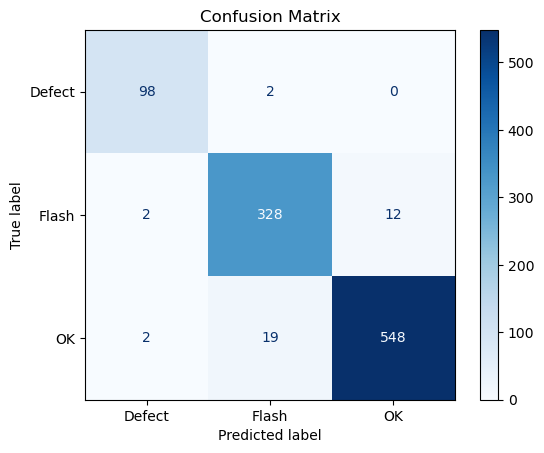

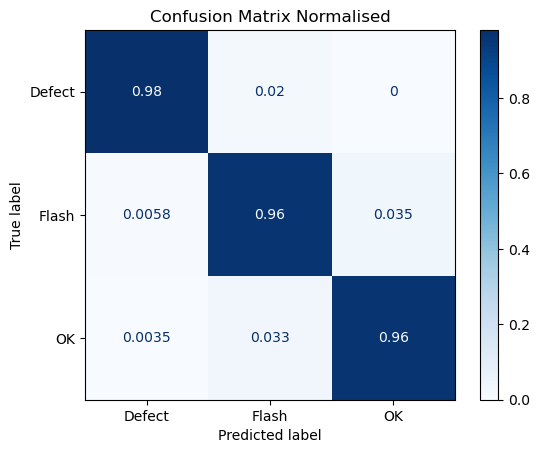

In [10]:
# Plot confusion matrix
disp_real = ConfusionMatrixDisplay(confusion_matrix=cm_real, display_labels=class_names)
disp_real.plot(cmap='Blues')
plt.title("Confusion Matrix")
# plt.savefig("ResNet18_CeramicCore_confusionmatrix.png") # uncomment to save the confusion matrix as a .png
plt.show()

disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp_norm.plot(cmap='Blues')
plt.title("Confusion Matrix Normalised")
# plt.savefig("RN18_CeramicCore_confusionmatrix_norm.png") # uncomment to save the normalised confusion matrix as a .png
plt.show()

This final cell plots the training and validation losses across training epochs. If the validation loss curve diverges from the training curve during later epochs, overfitting is likely happening. If this happens, the models performance on unseen data will be worsened.

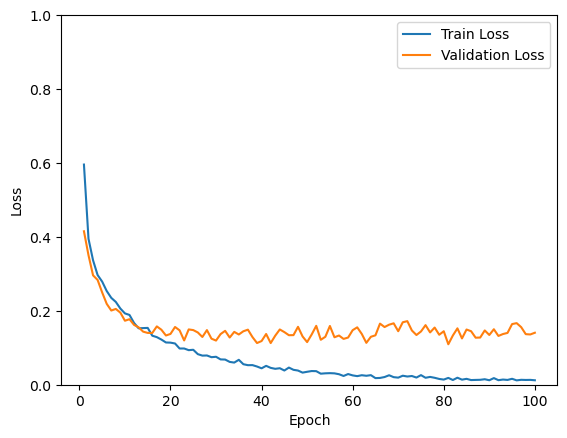

In [11]:
# Plot training and validation losses
xaxis = np.arange(1,num_epochs + 1)
plt.plot(xaxis, train_losses, label='Train Loss')
plt.plot(xaxis, val_losses, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.legend()
# plt.savefig("RN18_CeramicCore_losscurves.png") # uncomment to save the loss curves as a .png
plt.show()

# Summary

The model should now be trained! 

The saved weights file can be inserted into the dashboard application for testing on newly manufactured cores.
